In [1]:
import bs4
from selenium import webdriver
import requests
import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import authentication
import praw
from psaw import PushshiftAPI
import datetime as dt
import json
import sys
import os
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline
plt.style.use('fivethirtyeight')


## Downloading the parent dataframe from the PushShift API

### PushShift API allows you to collect data from a particular date range, which the Reddit API doesn't allow you to. 
### Step 1: collect the unique ID of each submission in this date range from the PushShift API. 
### Step 2: use the ID for each of these submissions to retrieve interesting and up-to-date information from the official Reddit API.

In [172]:
# This is how we retrieve all the information that we need from the reddit pushshift API
# The pushshift API allows us to retrieve posts from a particular date range, which the reddit API does not. 
# Info from the reddit API is slower to get hold of (more on that later), but more accurate and up to date, 
# especially for scores (i.e. upvotes), which is going to be our main metric.
# We will use the post id retrieved from the pushshift API 
# to get the actual score data from the reddit api itself.

api = PushshiftAPI()

end_of_search = int(dt.datetime(2020, 4, 21, 19, 0, 0).timestamp())
start_epoch = int(dt.datetime(2015, 1, 1, 0, 0, 0).timestamp())
end_epoch =  int(dt.datetime(2015, 1, 2, 0, 0, 0).timestamp())


parent_df = pd.DataFrame()

while start_epoch < end_of_search:
    print(dt.datetime.fromtimestamp(start_epoch))
    day_posts = api.search_submissions(after=start_epoch,
                                before=end_epoch,
                                subreddit='science',
                                filter=['title', 'author', 'id'],
                                limit=1000)
    
    temp_df = pd.DataFrame([post.d_ for post in day_posts])
        
    parent_df = parent_df.append(temp_df)
    start_epoch += 3600*24
    end_epoch += 3600*24
    
    
parent_df.to_csv('parent_dataframe_2015_2020.csv')

    


2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00


In [2]:
# We know have all the relevant post ids for the date range that we're interested in, 
# from 01/01/2015 to 04/21/2020, corresponding to approx. 2.5e5 posts

initial_df = pd.read_csv('parent_dataframe_2015_2020.csv', index_col=0)
initial_df.head()

,author,created,created_utc,id,title
0,presaging,1.420211e+09,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea..."
1,David07z,1.420210e+09,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...
2,mystypristy,1.420210e+09,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT
3,swill128,1.420209e+09,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...
4,babubro,1.420209e+09,1420183433,2r2z0p,Upcoming google project Space elevator must re...


In [4]:
initial_df.shape

(256053, 5)

In [5]:
# Some posts were deleted
initial_df[initial_df.title.str.contains('deleted by user')].head()
# '[deleted by user]' is the nan in title field

,author,created,created_utc,id,title
31,ugur125,1.536733e+09,1536707606,9f2djq,[deleted by user]
39,ugur125,1.536726e+09,1536700396,9f1fsw,[deleted by user]
40,ugur125,1.536726e+09,1536700395,9f1fsk,[deleted by user]
41,MrAbdulazizSobh,1.536725e+09,1536700097,9f1eci,[deleted by user]
45,johnypapa01,1.536723e+09,1536697596,9f125w,[deleted by user]


In [6]:
# How many do we have? 
initial_df[initial_df.title.str.contains('deleted by user')].shape

# Very few in relation to the number of actual posts that we have
# There may be more deleted posts once we access the reddit API (more up to date information)

(5, 5)

In [10]:
# Some authors have deleted their accounts
initial_df[initial_df.author.str.contains('deleted')].head()
# '[deleted]' is the nan in the author field

,author,created,created_utc,id,title
22,[deleted],1.420190e+09,1420164700,2r25yf,Oncologists says why they should lift ban on c...
29,[deleted],1.420184e+09,1420158313,2r1vb4,Events not to miss in 2015
30,[deleted],1.420183e+09,1420158125,2r1uy9,"Relating the ""right to try"" bill to biochemist..."
32,[deleted],1.420180e+09,1420154355,2r1oh9,"Little change seen in fast food portion size, ..."
46,[deleted],1.420165e+09,1420140128,2r0zig,How to make an origami universe


In [8]:
# How many deleted authors do we have? 
initial_df[initial_df.author.str.contains('[deleted]', regex=False)].shape
# A lot more, ~ 10% of data has no author name.


(29977, 5)

In [11]:
# Let's create a new variable which is human-readable time
initial_df['date'] = initial_df.progress_apply(lambda x: dt.datetime.fromtimestamp(x.created_utc), axis = 1)

100%|██████████| 256053/256053 [00:04<00:00, 52243.68it/s]


### Step 1 is complete, we have collected the ID of all the posts from the date range we will be focusing on.
### Now, to step 2: use the posts ID to retrieve information about those posts from the Reddit API. 
### We will be retrieving the following information: number of upvotes, URL of post, field (also referred to as link flair but in r/science really refers to the field of science of the post), and author flair (which refers to educational credentials)

### Problem: the Reddit API limits us to ~ 60 calls/minute. Given that we have 250000 rows, this will take 72 hours to download. 
### Solution: split the data into 10 chunks of 25000 rows, and use 10 different user accounts to retrieve the information about the chunks separately. Divide retrieval time by a factor of 10.

In [378]:
counter = 0
file_no = 1
while counter < initial_df.shape[0]:
    df_chunk = initial_df[['author', 'id']][counter:counter+26000]
    df_chunk.to_csv('datasets/test' + str(file_no) + '.csv')
    counter += 26000
    file_no += 1


In [ ]:

class API_call:
    """Submission needs to be a pandas series of Reddit submission IDs"""

    def __init__(self, client_id, client_secret, user_agent, submissions):
        self.client_id = client_id
        self.client_secret = client_secret
        self.user_agent = user_agent
        self.reddit = praw.Reddit(client_id=self.client_id,
                                 client_secret=self.client_secret,
                                 user_agent=self.user_agent)

        self.list_of_submissions = pd.read_csv(submissions,
                                              index_col=0).iloc[:,1]
        self.list_of_authors = pd.read_csv(submissions,
                                          index_col=0).iloc[:,0]


    def get_data(self):
        url = [None] * len(self.list_of_submissions)
        author_flair = [None] * len(self.list_of_submissions)
        field = [None] * len(self.list_of_submissions)
        upvotes = [None] * len(self.list_of_submissions)
        df = pd.DataFrame(columns=['id',
                                  'username',
                                  'url',
                                  'author_flair',
                                  'field',
                                  'upvotes'])

        counter = -1
        for author,post_id in zip(self.list_of_authors,
                                   self.list_of_submissions):
            counter += 1
            try:
                temp = self.reddit.submission(post_id)
                url[counter] = temp.url
                field[counter] = temp.link_flair_text
                author_flair[counter] = temp.author_flair_text
                upvotes[counter] = temp.ups

            except Exception:
                print('Hit an error with submission id: ' + post_id)
                print('Continuing...')
                continue

            if counter%500 == 0:
                print(counter)


        df.id = self.list_of_submissions
        df.username = self.list_of_authors
        df.url = url
        df.field = field
        df.author_flair = author_flair
        df.upvotes = upvotes

        df.to_csv(self.client_id + '.csv')

        print('Program complete!')

if __name__ == '__main__':
    if len(sys.argv) == 5:
        API_call(sys.argv[1], sys.argv[2], sys.argv[3],\
                sys.argv[4]).get_data()

    else:
        print('Usage: %s client_id client_secret user_agent submissions'\
              %sys.argv[0])


### Run a dedicated script via the command line to collect the data that we want from Reddit API.

In [12]:
# The data output is now in 10 different .csv files, let's combine all of them
# command to run: cat *.csv > combined.csv
# Load this dataset into memory, we'll want to merge it with our original dataframe by id

data_from_reddit = pd.read_csv('datasets/data_from_reddit_API/combined.csv', index_col=0).reset_index(drop=True)
data_from_reddit.head()


,id,username,url,author_flair,field,upvotes,gilded
0,9ybw5x,lily_y,https://www.statesboroherald.com/local/associa...,NaN,Biology,4,NaN
1,9ybkht,[deleted],https://academic.oup.com/jnen/advance-article/...,NaN,Medicine,1,NaN
2,9ybi5v,AISP_Insects,http://eprints.bbk.ac.uk/23400/,NaN,Environment,12,NaN
3,9ybhmh,[deleted],http://eprints.bbk.ac.uk/23400/,NaN,Environment,1,NaN
4,9ybh3m,[deleted],http://eprints.bbk.ac.uk/23400/,NaN,Environment,1,NaN


In [13]:
# Now let's merge this dataframe with the parent one, initial_df

initial_df.head()

,author,created,created_utc,id,title,date
0,presaging,1.420211e+09,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50
1,David07z,1.420210e+09,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49
2,mystypristy,1.420210e+09,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48
3,swill128,1.420209e+09,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26
4,babubro,1.420209e+09,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53


In [14]:
# total_df will be the dataframe that contains the information from both pushshift + reddit
# without gilding information, and without upvote ratio (will need to get those later)

total_df = initial_df.merge(data_from_reddit, on='id', how='left')
total_df.shape

(256053, 12)

In [15]:
total_df.head()

,author,created,created_utc,id,title,date,username,url,author_flair,field,upvotes,gilded
0,presaging,1.420211e+09,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,NaN
1,David07z,1.420210e+09,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,NaN
2,mystypristy,1.420210e+09,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,NaN
3,swill128,1.420209e+09,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,NaN
4,babubro,1.420209e+09,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,NaN


In [23]:
# Let's do a little bit of cleaning, we don't need all the columns here
# created is redundant, gilded can be removed as the column hasn't been populated yet
total_df.drop(['created', 'gilded', 'author'], axis=1, inplace=True)
total_df.head()

,created_utc,id,title,date,username,url,author_flair,field,upvotes,score
0,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,559
1,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,0
2,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,1
3,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,0
4,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,1


In [24]:
# Let's convert the upvotes col to ints (currently str, which makes comparisons/sorting impossible)

total_df['score'] = total_df.upvotes.astype('int')

In [25]:
# Let's drop the column upvotes as it's not useful anymore
total_df.drop('upvotes', axis=1, inplace=True)

In [28]:
# How many submissions have author_flair? 
total_df[total_df.author_flair.isna()==False].sort_values('score', ascending=False)
# Approximately 15000 rows

,created_utc,id,title,date,username,url,author_flair,field,score
221077,1554901897,bblu6v,The first picture of a black hole opens a new ...,2019-04-10 06:11:37,Science_News,https://www.sciencenews.org/article/black-hole...,Science News,Physics,155293
166480,1511108647,7e1jo1,Raising the taxes of graduate students by as m...,2017-11-19 08:24:07,nate,https://www.reddit.com/r/science/comments/7e1j...,PhD | Chemistry | Synthetic Organic,Subreddit Discussion,124375
173517,1516633319,7s6a9z,No evidence to support link between violent vi...,2018-01-22 07:01:59,mvea,https://www.york.ac.uk/news-and-events/news/20...,MD-PhD-MBA | Clinical Professor/Medicine,Psychology,114566
232655,1566128489,cs072c,"Having kids makes you happier, but only when t...",2019-08-18 04:41:29,mvea,https://www.newscientist.com/article/2213655-h...,MD-PhD-MBA | Clinical Professor/Medicine,Psychology,104586
219943,1553774691,b6hy7e,Woman with ‘mutant’ gene who feels no pain and...,2019-03-28 05:04:51,mvea,https://www.independent.co.uk/news/health/heal...,MD-PhD-MBA | Clinical Professor/Medicine,Medicine,101695
239692,1572778018,dqysmm,Scientists replaced 40 percent of cement with ...,2019-11-03 02:46:58,mvea,https://newatlas.com/materials/rubbery-crack-r...,MD-PhD-MBA | Clinical Professor/Medicine,Chemistry,97215
230811,1564104353,chwg8s,Tree stumps that should be dead can be kept al...,2019-07-25 18:25:53,mvea,https://www.newscientist.com/article/2211209-t...,MD-PhD-MBA | Clinical Professor/Medicine,Biology,92355
172580,1515882557,7q7rmw,A sea turtle’s sex is determined by the temper...,2018-01-13 14:29:17,SirT6,https://news.nationalgeographic.com/2018/01/au...,PhD|MBA|Biology|Biogerontology,Biology,89422
214948,1549027777,am2056,"Self-driving cars will ""cruise"" to avoid payin...",2019-02-01 05:29:37,mvea,https://news.ucsc.edu/2019/01/millardball-vehi...,MD-PhD-MBA | Clinical Professor/Medicine,Social Science,89216
212255,1546897129,admli1,"The United States, on a per capita basis, spen...",2019-01-07 13:38:49,mvea,https://www.jhsph.edu/news/news-releases/2018/...,MD-PhD-MBA | Clinical Professor/Medicine,Health,89157


(array([7815., 2316., 1305.,  877.,  649.,  509.,  401.,  355.,  297.,
         282.,  246.,  236.,  190.,  164.,  183.,  155.,  143.,  136.,
         132.,   99.,  119.,   98.,   93.,   69.,   85.,   71.,   72.,
          73.,   70.,   62.,   54.,   49.,   50.,   37.,   38.,   53.,
          36.,   48.,   39.,   41.,   38.,   32.,   31.,   37.,   33.,
          34.,   23.,   31.,   33.,   24.,   38.,   24.,   32.,   32.,
          27.,   14.,   18.,   28.,   22.,   26.,   18.,   26.,   15.,
          19.,   23.,   20.,   19.,   25.,   24.,   19.,   26.,   15.,
          23.,   16.,   24.,   17.,   13.,   19.,   19.,   15.,   27.,
          15.,   20.,   15.,   26.,   19.,   24.,   19.,   21.,   21.,
          17.,   22.,   18.,   21.,   10.,   15.,   17.,   21.,   11.,
          12.]),
 array([  100.,   299.,   498.,   697.,   896.,  1095.,  1294.,  1493.,
         1692.,  1891.,  2090.,  2289.,  2488.,  2687.,  2886.,  3085.,
         3284.,  3483.,  3682.,  3881.,  4080.,  4279.,  4

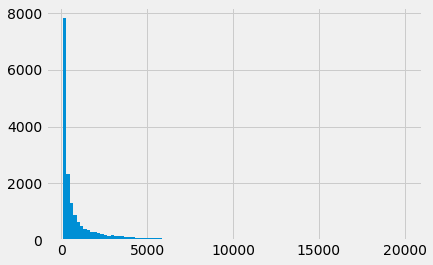

In [29]:
# OK, let's take a look at the distribution of scores
# Heavily right-skewed distribution
plt.hist(total_df.score, 100, range=(100,20000))

In [30]:
# We've collected the gilding + upvote_ratio data, so let's merge those with the parent dataframe, total_df. 
# Currently that data is sitting in gilding_upvote_ratio_data_from_reddit_API/gilding_upvote_data_combined.csv
gilding_df = pd.read_csv('datasets/gilding_upvote_ratio_data_from_reddit_API/gilding_upvote_data_combined.csv',
                   index_col=0).reset_index(drop=True)
gilding_df.head()

,id,username,gilded,upvote_ratio
0,9ybw5x,lily_y,[None],0.73
1,9ybkht,[deleted],[None],1.0
2,9ybi5v,AISP_Insects,"[Comment(id='eemjnxb'), Comment(id='drlqm8k'),...",0.74
3,9ybhmh,[deleted],[None],1.0
4,9ybh3m,[deleted],[None],1.0


In [31]:
combined_df = total_df.merge(gilding_df, on=['id', 'username'], how='left')
combined_df.head()

,created_utc,id,title,date,username,url,author_flair,field,score,gilded,upvote_ratio
0,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,[],0.91
1,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,[None],0.4
2,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,[],1.0
3,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,[Comment(id='fo0d2i1')],0.54
4,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,[],1.0


In [34]:
# We now need to do a serious bit of cleaning, in particular, remove the fields that have odd values
# instead of NaN

# '[deleted by user]' is the nan in title field
combined_df.title.replace('[deleted by user]', np.nan, inplace=True)

# '[deleted]' is the nan in the username field
combined_df.username.replace('[deleted]', np.nan, inplace=True)

# '[]' and '[None]' are NaN in the gilded field
combined_df.gilded.replace({'[]' : np.nan, '[None]' : np.nan}, inplace=True)

# No NaN in the upvote_ratio column, currently str type, so let's change that to float
combined_df['upvote_ratio'] = combined_df.upvote_ratio.astype('int')


In [36]:

combined_df.head()

,created_utc,id,title,date,username,url,author_flair,field,score,gilded,upvote_ratio
0,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,NaN,0
1,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,NaN,0
2,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,NaN,1
3,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,[Comment(id='fo0d2i1')],0
4,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,NaN,1


### Transforming the gilded column into useful information

In [ ]:
# OK, now for the gilded column. The way the gilded column is currently set up
# it contains an array of all the gilds that a user has received (both for comments and submissions)
# We should split this data into two columns, one that contains the total number of gilds for the author 
# (i.e. the len of the array in the column gilded)
# and another one that tells you whether this particular post was gilded
# (i.e. if the gilded column contains the id of this particular submission)


In [37]:
# Let's add the total no of gilds for each user
# Unfortunately, the array that was returned for that column is now
# of type str. Complex to iterate through.
# Easier to just count the number of instances of 'submission' and 'comment' in the array and add them up
# Create a function that does just that. 

def count_gilds(row):
    gild_array = row.gilded
    try:
        return gild_array.count('Submission') + gild_array.count('Comment')
    except Exception:
        return np.nan

In [39]:
# Now implement it
combined_df['no_gilds_for_user'] = combined_df.progress_apply(count_gilds, axis=1)

100%|██████████| 256053/256053 [00:04<00:00, 53089.92it/s]


In [40]:
# OK, now we need to see if for each row, the post id is present in the gilded field
def post_gilded(row):
    if row.gilded != np.nan: 
        if row.id in str(row.gilded):
            return True
    return False



In [41]:
combined_df['post_gilded'] = combined_df.progress_apply(post_gilded, axis=1)

100%|██████████| 256053/256053 [00:09<00:00, 26325.71it/s]


In [43]:
# Let's also convert the date into a useable object
combined_df['date'] = pd.to_datetime(combined_df['date'])

## Extract useful information from author flair
### Split into categorical variables relating to degree type: Professor, PhD, MA/MS, BA/BS


In [44]:
# Only ~ 15000 posts have an author flair associated with them
combined_df.author_flair.isna().value_counts()

True     241363
False     14690
Name: author_flair, dtype: int64

In [45]:
flair_df = combined_df[['id', 'author_flair']][combined_df.author_flair.isna() == False]

In [95]:
set(flair_df[(flair_df.author_flair.str.contains('MD'))].author_flair)

{'DMD | Orthodontics',
 'DMD | Orthodontist',
 'MD PhD | CEO Lyfebulb',
 'MD PhD|Molecular Cell Biology|Radiology',
 'MD Student | Medicine',
 'MD | Clinical Laboratory ',
 'MD | Clinical Neurosciences',
 'MD | Deputy Director | National Institute on Drug Abuse',
 'MD | Duke University | Ganogen, Inc.',
 'MD | Emergency Medicine',
 'MD | Internal Medicine',
 'MD | Internal medicine',
 'MD | Interventional Radiology',
 'MD | Karolinska University Hospital in Sweden',
 'MD | MBA | Medicine',
 'MD | MPH | GDCompSci | Epidemiology|Bioinformatics',
 'MD | Medicine',
 'MD | Medicine ',
 'MD | Medicine | Marijuana ',
 'MD | Medicine | Radiology ',
 "MD | Medicine | Seattle Children's Research Institute",
 'MD | Neurology',
 'MD | Neurosurgery',
 'MD | Neurosurgery Resident',
 'MD | NewYork-Presbyterian/Columbia University Medical Center',
 'MD | Obstetrician Gynecologist | The Skeptical OB',
 'MD | Palliative Care',
 'MD | Pathology',
 'MD | Pediatrics | Neonatology',
 'MD | PhD Neuroscience'

### For our purposes, we will group MD and PhD into the same category. 
#### Want to make sure that AMAs don't get grouped with MA

In [46]:
def get_degree_type(row):
    if 'Prof' in row.author_flair:
        return 'Professor'
    if 'PhD' in row.author_flair or 'MD' in row.author_flair:
        return 'PhD'
    if 'MS' in row.author_flair or ('MA' in row.author_flair and 'AMA' not in row.author_flair):
        return 'Master'
    if 'BS' in row.author_flair or ('BA' in row.author_flair and 'MBA' not in row.author_flair) \
    or 'Grad Student' in row.author_flair:
        return 'Bachelors'

    return np.nan

In [47]:
flair_df['degree'] = flair_df.progress_apply(get_degree_type, axis=1)

100%|██████████| 14690/14690 [00:00<00:00, 21067.64it/s]


In [48]:
set(flair_df[flair_df.degree.isna()].author_flair)

{' Aviator/Author | X PRIZE Foundation',
 ' Biomedical Engineer | Washington University in St. Louis',
 ' Chicxulub Impact Crater Scientists',
 ' Exploration Vessel E/V Nautilus |The Ocean Exploration Trust | ',
 ' Former NASA astronaut | 100 Year Starship ',
 ' Head of Scientific Diving|California Academy of Science',
 ' In Vitro ADMET Laboratories ',
 ' Project Director for the Giant Magellan Telescope',
 '314 Action',
 '97% Climate Consensus Researchers ',
 'AAAS AMA Guest',
 'AAAS AMA | Workplace Bullying',
 'AAAS Annual Meeting AMA Guests',
 'AAAS Climate Scientists',
 'AAAS Guests ',
 'ADMX Collaboration',
 'AL.com AMA Account',
 'APHL Food Safety Laboratory Scientists',
 "Accessible Genetics Consortium | Goldsmith's, U of London ",
 'Addiction Psychiatrist | McLean Hospital',
 'Adriano Lameira | Durham University',
 'Amateur Scientist and Author',
 'Ambassador - NASA/JPL',
 'American Chemical Society AMA Guest',
 'American Council on Science and Health',
 'American Geophysical U

In [49]:
# Now, we need to merge this degree column back with the original dataframe


In [51]:
flair_df = flair_df[['id','degree']]

In [52]:
combined_df = combined_df.merge(flair_df, on='id', how='left')

In [54]:
combined_df.head()

,created_utc,id,title,date,username,url,author_flair,field,score,gilded,upvote_ratio,no_gilds_for_user,post_gilded,degree
0,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,NaN,0,NaN,False,NaN
1,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,NaN,0,NaN,False,NaN
2,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,NaN,1,NaN,False,NaN
3,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,[Comment(id='fo0d2i1')],0,1.0,False,NaN
4,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,NaN,1,NaN,False,NaN


In [57]:
# Before we save the dataset, turns out Computer Science also has another alias, which is Computer Sci 
# in the field column, let's change that

combined_df.field.replace({'Computer Sci': 'Computer Science'}, inplace=True)

In [58]:
# Let's calculate the title length in words
combined_df['length_of_title_words'] = combined_df.apply(lambda row: len(row.title.split())\
                                            if type(row.title) == str\
                                            else np.nan, axis=1)

In [59]:
# Let's calculate the title length in characters
combined_df['length_of_title_char'] = combined_df.apply(lambda row: len(row.title)\
                                            if type(row.title) == str\
                                            else np.nan, axis=1)

In [61]:
# Let's also calculate the average word length

combined_df['average_word_length'] = combined_df.length_of_title_char / combined_df.length_of_title_words
combined_df['average_word_length'] = combined_df.average_word_length.apply(lambda x: float("{:.1f}".format(x)))

In [63]:
# Let's also calculate the time of day at which the post was created

combined_df['time_of_day_PST'] = combined_df.apply(lambda row: dt.datetime.fromtimestamp(row.created_utc).hour, axis=1)




In [64]:
# Let's extract the day of the week on which post was created
combined_df['day_of_the_week'] = combined_df.apply(lambda row: dt.datetime.fromtimestamp(row.created_utc).\
                                             weekday(), axis=1)



### We have the number of comments, let's incorporate those

In [71]:
comments_df = pd.read_csv('datasets/num_comments_data_from_reddit_API/combined_num_comments.csv',
                          index_col=0).reset_index(drop=True)

In [73]:
comments_df.head()

,id,username,num_comments
0,9ybw5x,lily_y,2
1,9ybkht,[deleted],0
2,9ybi5v,AISP_Insects,2
3,9ybhmh,[deleted],1
4,9ybh3m,[deleted],1


In [74]:
# Let's merge this back with the parent dataframe

In [76]:
combined_df = combined_df.merge(comments_df[['id', 'num_comments']], on='id', how='left')

In [80]:
combined_df.num_comments = combined_df.num_comments.astype('int')

In [84]:
# Let's save this dataframe! 
combined_df.to_csv('complete_final_dataframe_042820.csv', index=False)